SH Index Creation - spatially averaging sea-level pressure over
the region 80–120°E, 40–65°N (Panagiotopoulos et al.
2005).

In [1]:
##### Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt


In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/composites/'      # figures


In [3]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

# Select lat/lon grid
lonmin = 80
lonmax = 120
latmin = 40
latmax = 65

f = xr.open_mfdataset(path_to_data + 'ERA5/mslp/daily/out*.nc' , preprocess=preprocess, combine='by_coords')
f

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 41, longitude: 81, time: 14610)
Coordinates:
  * longitude  (longitude) float32 80.0 80.5 81.0 81.5 ... 119.0 119.5 120.0
  * latitude   (latitude) float32 60.0 59.5 59.0 58.5 ... 41.5 41.0 40.5 40.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(365, 41, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Jun 30 13:39:56 2020: cdo daymean era5_hma_025dg_6hr_ms...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.0rc3 (http://mpimet.mpg....

In [4]:
# resample to seasonal means
# convert to hPa
ds = f.resample(time="QS-DEC").mean()/100


In [5]:
# spatial average
SH = ds.mean(['latitude', 'longitude'])
# standard deviation
SH_std = ds.std(['latitude', 'longitude'])

In [6]:
# Select months
idx = (SH.time.dt.month >= 12) | (SH.time.dt.month <= 2)
SH = SH.sel(time=idx)
SH

<xarray.Dataset>
Dimensions:  (time: 41)
Coordinates:
  * time     (time) datetime64[ns] 1978-12-01 1979-12-01 ... 2018-12-01
Data variables:
    msl      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [7]:
X1 = SH
# Standardize by column and remove column mean
x1mean = np.mean(X1.msl).values
x1std = np.std(X1.msl).values

X = (X1 - x1mean) / x1std

In [8]:
# # Vector of AR dates
# dates =  X.time.values

# # Create new dataframe
# data = {'SH':X.msl.values}
# df_out = pd.DataFrame(data, index=dates)

# # Export dataframe as csv
# outfile = path_to_out + 'SH_index_ERA5_1979_2019.csv'
# df_out.to_csv(outfile)
# print(outfile)

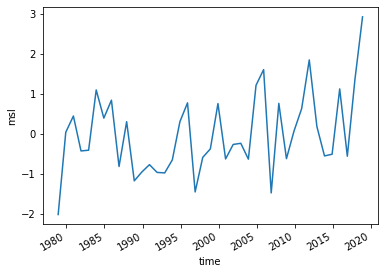

In [9]:
X.msl.plot()

In [10]:
# Vector of AR dates
dates =  X.time.values

# Create new dataframe
data = {'SH':X.msl.values}
df_out = pd.DataFrame(data, index=dates)

# Export dataframe as csv
outfile = path_to_out + 'SH_index_ERA5_1979_2019_DJF.csv'
df_out.to_csv(outfile)
print(outfile)

/home/nash/DATA/repositories/AR_types/out/SH_index_ERA5_1979_2019_DJF.csv


In [11]:
# date array with all days
dates_allDays = pd.date_range('1978-12-01', '2018-12-01', freq='QS-DEC')
cat_allDays = np.zeros(len(dates_allDays), dtype=np.float)
cat_allDays[:] = np.nan

# Loop over ar days and match to ar_full 
for i, date in enumerate(df_out.index):
    idx = np.where(dates_allDays == date)
    cat_allDays[idx] = df_out['SH'].values[i]

# Create dataframe
data = {'ANOM':cat_allDays}
df_all = pd.DataFrame(data, index=dates_allDays)
df_all = df_all['ANOM'].ffill(axis = 0)
df_all

1978-12-01   -2.007388
1979-03-01   -2.007388
1979-06-01   -2.007388
1979-09-01   -2.007388
1979-12-01    0.048904
                ...   
2017-12-01    1.366491
2018-03-01    1.366491
2018-06-01    1.366491
2018-09-01    1.366491
2018-12-01    2.934641
Freq: QS-DEC, Name: ANOM, Length: 161, dtype: float64

In [12]:
# Export dataframe as csv
outfile = path_to_out + 'SH_index_ERA5_1979_2019.csv'
df_all.to_csv(outfile)
print(outfile)

/home/nash/DATA/repositories/AR_types/out/SH_index_ERA5_1979_2019.csv
